# Appliances energy prediction 


The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. 

The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column. 

Two random variables have been included in the data set for testing the regression models and to filter out non predictive attributes (parameters).

### Attribute Information
- **date**: time year-month-day hour:minute:second
- **Appliances**: energy use in Wh
- **lights**: energy use of light fixtures in the house in Wh
- **T1**: Temperature in kitchen area, in Celsius
- **RH_1**: Humidity in kitchen area, in %
- **T2**: Temperature in living room area, in Celsius
- **RH_2**: Humidity in living room area, in %
- **T3**: Temperature in laundry room area
- **RH_3**: Humidity in laundry room area, in %
- **T4**: Temperature in office room, in Celsius
- **RH_4**: Humidity in office room, in %
- **T5**: Temperature in bathroom, in Celsius
- **RH_5**: Humidity in bathroom, in %
- **T6**: Temperature outside the building (north side), in Celsius
- **RH_6**: Humidity outside the building (north side), in %
- **T7**: Temperature in ironing room , in Celsius
- **RH_7**: Humidity in ironing room, in %
- **T8**: Temperature in teenager room 2, in Celsius
- **RH_8**: Humidity in teenager room 2, in %
- **T9**: Temperature in parents room, in Celsius
- **RH_9**: Humidity in parents room, in %
- **To**: Temperature outside (from Chievres weather station), in Celsius
- **Pressure**: (from Chievres weather station), in mm Hg
- **RH_out**: Humidity outside (from Chievres weather station), in %
- **Wind speed**: (from Chievres weather station), in m/s
- **Visibility**: (from Chievres weather station), in km
- **Tdewpoint**: (from Chievres weather station), Â°C
- **rv1**: Random variable 1, nondimensional
- **rv2**: Random variable 2, nondimensional

Where indicated, hourly data (then interpolated) from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis, rp5.ru. Permission was obtained from Reliable Prognosis for the distribution of the 4.5 months of weather data.

In [1]:
import warnings
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
from statsmodels.tsa.seasonal import seasonal_decompose

# import hana_ml
# from hana_ml import dataframe

warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'

plt.rc('font', size=16)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)
plt.rc('figure', titlesize=18)
plt.rc('figure', figsize=(16,16))

plt.style.use('seaborn-whitegrid')
pd.set_option('display.precision', 1)
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data/energydata_complete.csv')
df['date'] = pd.to_datetime(df['date'])
df['energy'] = df['Appliances'] + df['lights']

In [3]:
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,energy
0,2016-01-11 17:00:00,60,30,19.9,47.6,19.2,44.8,19.8,44.7,19.0,45.6,17.2,55.2,7.0,84.3,17.2,41.6,18.2,48.9,17.0,45.5,6.6,733.5,92.0,7.0,63.0,5.3,13.3,13.3,90
1,2016-01-11 17:10:00,60,30,19.9,46.7,19.2,44.7,19.8,44.8,19.0,46.0,17.2,55.2,6.8,84.1,17.2,41.6,18.2,48.9,17.1,45.6,6.5,733.6,92.0,6.7,59.2,5.2,18.6,18.6,90
2,2016-01-11 17:20:00,50,30,19.9,46.3,19.2,44.6,19.8,44.9,18.9,45.9,17.2,55.1,6.6,83.2,17.2,41.4,18.2,48.7,17.0,45.5,6.4,733.7,92.0,6.3,55.3,5.1,28.6,28.6,80
3,2016-01-11 17:30:00,50,40,19.9,46.1,19.2,44.6,19.8,45.0,18.9,45.7,17.2,55.1,6.4,83.4,17.1,41.3,18.1,48.6,17.0,45.4,6.2,733.8,92.0,6.0,51.5,5.0,45.4,45.4,90
4,2016-01-11 17:40:00,60,40,19.9,46.3,19.2,44.5,19.8,45.0,18.9,45.5,17.2,55.1,6.4,84.9,17.2,41.2,18.1,48.6,17.0,45.4,6.1,733.9,92.0,5.7,47.7,4.9,10.1,10.1,100


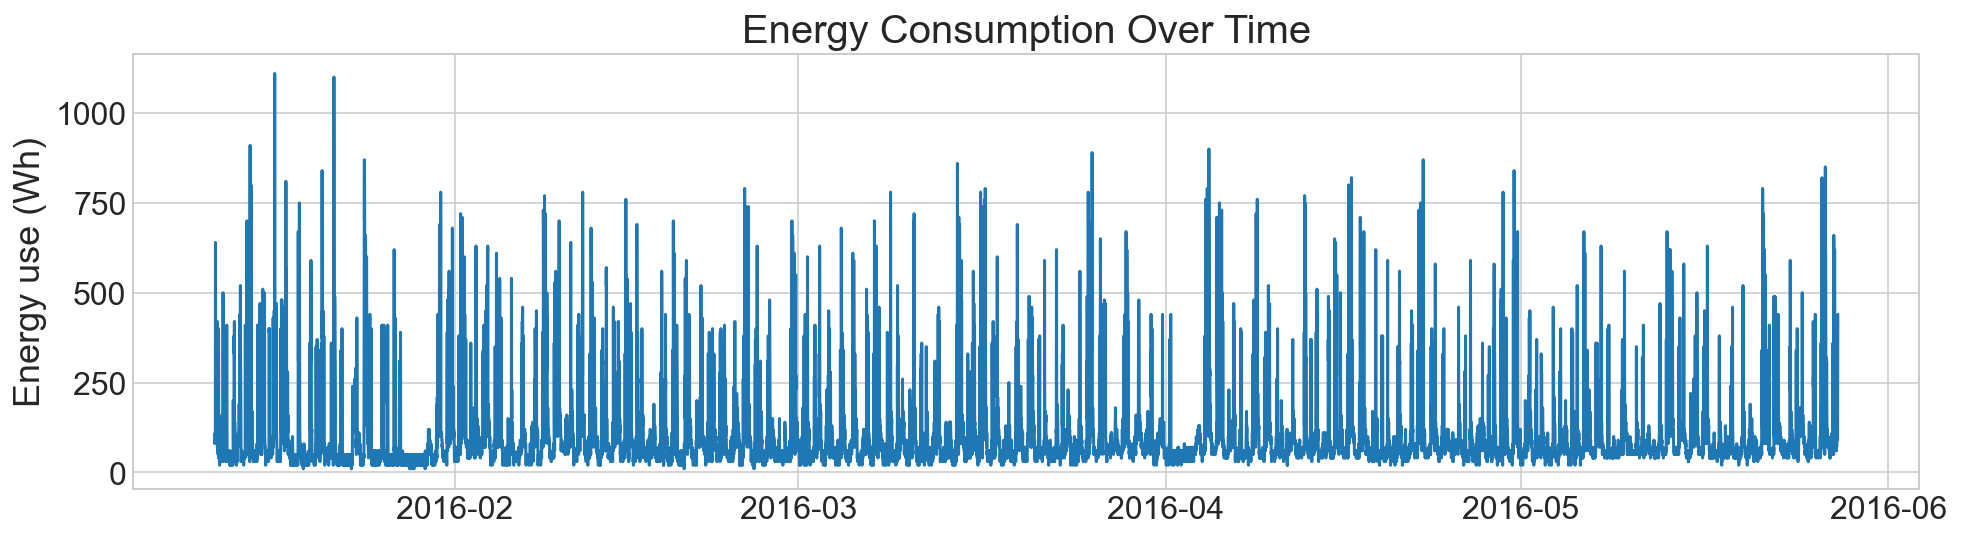

In [4]:
plt.figure(figsize=(16,4))
plt.plot(df['date'], df['energy'])
plt.title("Energy Consumption Over Time", fontsize=20)
plt.ylabel('Energy use (Wh)', fontsize=18)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
# plt.yscale('log')
plt.show()

Group by hour because there are missing 10-min interval datapoints

In [5]:
df_hourly = pd.DataFrame(df.resample('H', on='date').mean()) 
df_daily = pd.DataFrame(df.resample('D', on='date').mean()) 
n_days = len(df_daily)

TRAIN_LEN = round(0.7976 * len(df_hourly))
train_df = df_hourly[:TRAIN_LEN]
test_df = df_hourly[TRAIN_LEN:]

n_days_train = len(pd.DataFrame(train_df.reset_index().resample('D', on='date').mean()))
n_days_test = len(pd.DataFrame(test_df.reset_index().resample('D', on='date').mean()))
print("{} total days, {} train days, {} test days".format(n_days, n_days_train, n_days_test))

138 total days, 111 train days, 28 test days


### Causality investigation

First, we use Granger Causality Test to investigate causality of data. Granger causality is a way to investigate the causality between two variables in a time series which actually means if a particular variable comes before another in the time series. In the MTS, we will test the causality of all combinations of pairs of variables.

The Null Hypothesis of the Granger Causality Test is that lagged x-values do not explain the variation in y, so the x does not cause y. We use grangercausalitytests function in the package statsmodels to do the test and the output of the matrix is the minimum p-value when computes the test for all lags up to maxlag. The critical value we use is 5% and if the p-value of a pair of variables is smaller than 0.05, we could say with 95% confidence that a predictor x causes a response y.

In [11]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag = 12
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [12]:
matrix = grangers_causation_matrix(df_hourly, variables = df_hourly.columns)  

In [7]:
# matrix < 0.05

### Cointegration test

Cointegration test helps to establish the presence of a statistically significant connection between two or more time series.

In [14]:
# from statsmodels.tsa.vector_ar.vecm import coint_johansen

# def cointegration_test(df, alpha=0.05): 
#     """Perform Johanson's Cointegration Test and Report Summary"""
#     out = coint_johansen(df, -1, 5)
#     d = {'0.90':0, '0.95':1, '0.99':2}
#     traces = out.lr1
#     cvts = out.cvt[:, d[str(1-alpha)]]
#     def adjust(val, length= 6): return str(val).ljust(length)

#     # Summary
#     print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
#     for col, trace, cvt in zip(df.columns, traces, cvts):
#         print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

# cointegration_test(df_hourly)

### Stationary test

As VectorARIMA requires time series to be stationary, we will use one popular statistical test – Augmented Dickey-Fuller Test (ADF Test) to check the stationary of each variable in the dataset. If the stationarity is not achieved, we need to make the data stationary, such as eliminating the trend and seasonality by differencing and seasonal decomposition.

In the following script, we use adfuller function in the statsmodels package for stationary test of each variables. The Null Hypothesis is that the data has unit root and is not stationary and the significant value is 0.05.

In [19]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 

    if p_value <= sig:
        print(f" {name} : P-Value = {p_value} => Stationary. ")
    else:
        print(f" {name} : P-Value = {p_value} => Non-stationary.")

for name, column in df_hourly.iteritems():
    adfuller_test(column, name=column.name)

 Appliances : P-Value = 0.0 => Stationary. 
 lights : P-Value = 0.0 => Stationary. 
 T1 : P-Value = 0.059 => Non-stationary.
 RH_1 : P-Value = 0.0 => Stationary. 
 T2 : P-Value = 0.056 => Non-stationary.
 RH_2 : P-Value = 0.0 => Stationary. 
 T3 : P-Value = 0.123 => Non-stationary.
 RH_3 : P-Value = 0.003 => Stationary. 
 T4 : P-Value = 0.181 => Non-stationary.
 RH_4 : P-Value = 0.003 => Stationary. 
 T5 : P-Value = 0.163 => Non-stationary.
 RH_5 : P-Value = 0.0 => Stationary. 
 T6 : P-Value = 0.005 => Stationary. 
 RH_6 : P-Value = 0.181 => Non-stationary.
 T7 : P-Value = 0.367 => Non-stationary.
 RH_7 : P-Value = 0.0 => Stationary. 
 T8 : P-Value = 0.042 => Stationary. 
 RH_8 : P-Value = 0.0 => Stationary. 
 T9 : P-Value = 0.667 => Non-stationary.
 RH_9 : P-Value = 0.001 => Stationary. 
 T_out : P-Value = 0.017 => Stationary. 
 Press_mm_hg : P-Value = 0.0 => Stationary. 
 RH_out : P-Value = 0.0 => Stationary. 
 Windspeed : P-Value = 0.0 => Stationary. 
 Visibility : P-Value = 0.0 => 

In [20]:
data_differenced = df_hourly.diff().dropna()
for name, column in data_differenced.iteritems():
    adfuller_test(column, name=column.name)

 Appliances : P-Value = 0.0 => Stationary. 
 lights : P-Value = 0.0 => Stationary. 
 T1 : P-Value = 0.0 => Stationary. 
 RH_1 : P-Value = 0.0 => Stationary. 
 T2 : P-Value = 0.0 => Stationary. 
 RH_2 : P-Value = 0.0 => Stationary. 
 T3 : P-Value = 0.0 => Stationary. 
 RH_3 : P-Value = 0.0 => Stationary. 
 T4 : P-Value = 0.0 => Stationary. 
 RH_4 : P-Value = 0.0 => Stationary. 
 T5 : P-Value = 0.0 => Stationary. 
 RH_5 : P-Value = 0.0 => Stationary. 
 T6 : P-Value = 0.0 => Stationary. 
 RH_6 : P-Value = 0.0 => Stationary. 
 T7 : P-Value = 0.0 => Stationary. 
 RH_7 : P-Value = 0.0 => Stationary. 
 T8 : P-Value = 0.0 => Stationary. 
 RH_8 : P-Value = 0.0 => Stationary. 
 T9 : P-Value = 0.0 => Stationary. 
 RH_9 : P-Value = 0.0 => Stationary. 
 T_out : P-Value = 0.0 => Stationary. 
 Press_mm_hg : P-Value = 0.0 => Stationary. 
 RH_out : P-Value = 0.0 => Stationary. 
 Windspeed : P-Value = 0.0 => Stationary. 
 Visibility : P-Value = 0.0 => Stationary. 
 Tdewpoint : P-Value = 0.0 => Stationar

In [10]:
# if necessary
# data_differenced2 = data_differenced.diff().dropna()
# for name, column in data_differenced2.iteritems():
#     adfuller_test(column, name=column.name)

# Model building

In [21]:
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic